Pour évaluer la stabilité de segmentation dans le temps : choisir une segmentation, le plus simple sera celle faite via kmeans.
Faire un kmeans sur une période de référence (probablement une année complète).
Faire ensuite glisser les périodes : M+1, M+2, M+3, etc
Utiliser le kmeans de la période de référence pour prédire les clusters sur les périodes glissantes.
Comparer les clusters prédits avec les clusters si on avait réentrainer le modèle sur la période glissante.
Faire une matrice de confusion pour voir comment se répartissent les clients.
Calculer l'indice de rand ajusté (class sklearn.metrics)
En déduire quand la segmentation doit etre mise à jour.


In [20]:
import pandas as pd
from sklearn.metrics import adjusted_rand_score

# train model sur des données puis Mois + 1 / M + 2
# kmeans (pickle) : load / predict / checker ARI score : si stable ou si ca change bcp et là doit refit

# bdd order_purchase / max - 1 mois avant / reprend tout et fit

# 3 sep
# fit bdd 3 / 08 - reprend bdd entiere predict 3/09 - / ARI (normalement decroissant)
# fit 03/07 / predict bdd / ARI
# nombre de mois : janvier / M+8 / lineplot (inf à 0.8/0.7 apres trois mois)

# trois 112000 / retirer les mois recents puis groupby // ne pas prendre les nouveaux clients (verifier si le modele tient sur la distance/ meme clients mais caracteristique diff)

# dbscan

### Importing libraries

In [21]:
%reset -f

from functions import *

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


In [22]:
# Starting time
t0 = time()

input_path = "./dataset/cleaned/"
input_filename = "merged_dataset.csv"

output_path = "./dataset/simulation/"

### Importing dataset

In [23]:
data = load_data(input_path, input_filename)

___Loading raw dataset___
Initial shape : (112650, 18)


In [24]:
data

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,1,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10
112646,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,1,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02
112647,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59
112648,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59


## I) Preparing simulation datasets

In [25]:
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'].astype(str), format='%Y/%m/%d') # .astype(str)

In [26]:
last_day_recorded = data["order_purchase_timestamp"].max()

print("Last day recorded in the dataset :", last_day_recorded, type(last_day_recorded))

print("Year :", last_day_recorded.year)
print("Month :", last_day_recorded.month)
print("Day :", last_day_recorded.day)

Last day recorded in the dataset : 2018-09-03 09:06:57 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Year : 2018
Month : 9
Day : 3


In [27]:
nb_days = 15

In [28]:
# Time limit
time_limit = max(data.order_purchase_timestamp) + relativedelta(days=-nb_days)

time_limit

Timestamp('2018-08-19 09:06:57')

In [29]:
data_previous_days = data.copy()
filter_date = data_previous_days["order_purchase_timestamp"] <= time_limit

data_previous_days = data_previous_days[filter_date]
print("Verification of the filter :", max(data_previous_days.order_purchase_timestamp))

Verification of the filter : 2018-08-19 08:57:45


In [30]:
data_previous_days = data_previous_days.groupby('customer_unique_id').agg({'order_purchase_timestamp' : lambda x: (time_limit - x.max()).days,
                                           'order_id' : pd.Series.nunique,
                                           'price' : 'sum',
                                           })
# Rename columns
dataset_rfm_previous_days = data_previous_days.rename(columns = {'order_purchase_timestamp' : 'Recency',
                                   'order_id' : 'Frequency',
                                   'price' : 'Monetary'}) #, inplace = True)

In [31]:
dataset_rfm_previous_days

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,100,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,103,1,18.90
0000f46a3911fa3c0805444483337064,526,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,310,1,25.99
0004aac84e0df4da2b147fca70cf8255,277,1,180.00
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,436,1,1570.00
fffea47cd6d3cc0a88bd621562a9d061,251,1,64.89
ffff371b4d645b6ecea244b27531430a,557,1,89.90


In [32]:
#columns_to_keep = ['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'price']

simulate_dataset(data, nb_days=15, nb_periods=11, output_path=output_path)

Step : 1 Maximum order purchase date : 2018-03-22 09:06:57

Verification of the filter : 2018-03-22 08:49:51
This dataset has 61879 unique clients
Step : 2 Maximum order purchase date : 2018-04-06 09:06:57

Verification of the filter : 2018-04-06 09:04:13
This dataset has 65121 unique clients
Step : 3 Maximum order purchase date : 2018-04-21 09:06:57

Verification of the filter : 2018-04-21 09:00:35
This dataset has 68407 unique clients
Step : 4 Maximum order purchase date : 2018-05-06 09:06:57

Verification of the filter : 2018-05-06 09:02:34
This dataset has 71881 unique clients
Step : 5 Maximum order purchase date : 2018-05-21 09:06:57

Verification of the filter : 2018-05-21 08:55:06
This dataset has 75772 unique clients
Step : 6 Maximum order purchase date : 2018-06-05 09:06:57

Verification of the filter : 2018-06-05 09:02:27
This dataset has 77917 unique clients
Step : 7 Maximum order purchase date : 2018-06-20 09:06:57

Verification of the filter : 2018-06-20 09:02:43
This data

## II) Simulation

### Simulation 1 : simulation over 6 months

In [58]:
X_T0 = pd.read_csv(output_path + "rfm_T0").drop("customer_unique_id", axis=1).copy()

In [59]:
X_T0

,Recency,Frequency,Monetary
0,376,1,69.00
1,160,1,25.99
2,127,1,180.00
3,21,1,382.00
4,382,1,135.00
...,...,...,...
61874,84,1,149.00
61875,286,1,1570.00
61876,101,1,64.89
61877,407,1,89.90


In [60]:
scaler = StandardScaler().fit(X_T0[X_T0.columns])

X_std_T0 = X_T0.copy()
X_std_T0[X_std_T0.columns] = scaler.transform(X_std_T0[X_std_T0.columns])
print(X_std_T0.shape)

X_std_T0

(61879, 3)


,Recency,Frequency,Monetary
0,1.792358,-0.162458,-0.336535
1,-0.043041,-0.162458,-0.538719
2,-0.323450,-0.162458,0.185262
3,-1.224155,-0.162458,1.134838
4,1.843341,-0.162458,-0.026277
...,...,...,...
61874,-0.688830,-0.162458,0.039535
61875,1.027608,-0.162458,6.719474
61876,-0.544377,-0.162458,-0.355855
61877,2.055771,-0.162458,-0.238286


#### PCA

In [64]:
from sklearn.decomposition import PCA

pca_T0 = PCA(n_components=2, random_state=0)
pca_T0.fit(X_std_T0)
print(pca_T0.explained_variance_ratio_.cumsum())

X_pca_T0 = pca_T0.transform(X_std_T0)

[0.36741408 0.70324483]


(-0.7, 0.7)

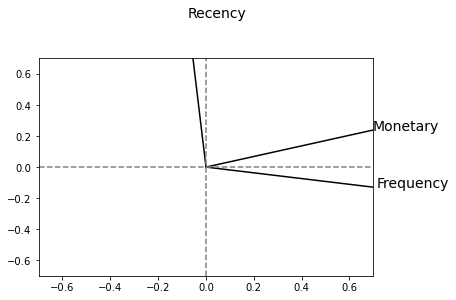

In [65]:
pcs = pca_T0.components_

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, X_std_T0.columns[i], fontsize='14')

# Afficher une ligne horizontale y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])

#### K-Means

In [66]:
from sklearn.cluster import KMeans

kmeans_cls_T0 = KMeans(n_clusters=5, verbose=0, random_state=0)
kmeans_cls_T0.fit(X_std_T0)

KMeans(n_clusters=5, random_state=0)

Text(0.5, 1.0, 'Visualizing clusters with PCA')

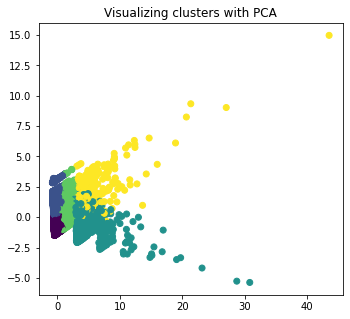

In [67]:
fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(121) # 1 en ordonnée / 2 en abcs / celle là la premiere
ax.scatter(x=X_pca_T0[:, 0], y=X_pca_T0[:, 1], c=kmeans_cls_T0.labels_) # colorier en fct etiquette deu clusterning
plt.title("Visualizing clusters with PCA")

#### T1 = T0 + 15 days

In [68]:
X_T1 = pd.read_csv(output_path + "rfm_T1").drop("customer_unique_id", axis=1).copy()

In [69]:
X_std_T1 = X_T1.copy()
scaler = StandardScaler()

X_std_T1[X_std_T1.columns] = scaler.fit_transform(X_std_T1)
print(X_std_T1.shape)

(65121, 3)


In [70]:
kmeans_cls_T1_new = KMeans(n_clusters=5, verbose=0, random_state=0)
kmeans_cls_T1_new.fit(X_std_T1)

KMeans(n_clusters=5, random_state=0)

In [71]:
kmeans_cls_T1_init = kmeans_cls_T0.predict(X_std_T1)

In [74]:
kmeans_cls_T1_new.labels_

array([0, 1, 1, ..., 1, 0, 0])

In [73]:
kmeans_cls_T1_init

array([1, 0, 0, ..., 0, 1, 1])

In [97]:
global simulation_results
simulation_results = pd.DataFrame({})

from sklearn.metrics import adjusted_rand_score


def evaluate_simulation(results, time, cls_init, cls_new):
    """

    :param simulation_results:
    :param time:
    :param cls_init:  (np array)
    :param cls_new:  (np array)
    :return:
    """
    print("ARI for T = {}")  # name Pandas Series
    ARI = adjusted_rand_score(cls_init, cls_new)

    results = pd.concat([results, pd.DataFrame({"T": [time],
                                              "ARI": [ARI]})], ignore_index=True)

    results = results.sort_values(by=["ARI"], ascending=False)
    display(results)
    return results

In [98]:
ARI_T1 = adjusted_rand_score(kmeans_cls_T1_init, kmeans_cls_T1_new.labels_) # Y true labels / pred labels
ARI_T1

0.9980689030904525

#### Evaluate ARI for all T (all periods)

In [99]:
nb_periods = 11

for t in range(1, nb_periods + 1):
    print("\n\n\nFor T =", t)
    # 1) we get the matrix X
    #X_T0 = pd.read_csv(output_path + "rfm_T0").drop("customer_unique_id", axis=1).copy()
    X = globals()["rfm_T" + str(t)]

    # 2) we scale the features
    X_std = X.copy()
    scaler = StandardScaler()
    X_std[X_std.columns] = scaler.fit_transform(X_std)
    print(X_std.shape)

    # 3) Clustering
    # new clustering
    kmeans_cls_new = KMeans(n_clusters=5, verbose=0, random_state=0)
    kmeans_cls_new.fit(X_std)
    print(kmeans_cls_new)

    # with initial clustering
    kmeans_cls_init = kmeans_cls_T0.predict(X_std)

    # 3) evaluation ARI
    simulation_results = evaluate_simulation(simulation_results, time=t, cls_init=kmeans_cls_init, cls_new=kmeans_cls_new.labels_)




For T = 1
(65121, 3)
KMeans(n_clusters=5, random_state=0)
ARI for T = {}


,T,ARI
0,1,0.998069





For T = 2
(68407, 3)
KMeans(n_clusters=5, random_state=0)
ARI for T = {}


,T,ARI
0,1,0.998069
1,2,0.989910





For T = 3
(71881, 3)
KMeans(n_clusters=5, random_state=0)
ARI for T = {}


,T,ARI
0,1,0.998069
1,2,0.989910
2,3,0.984113





For T = 4
(75772, 3)
KMeans(n_clusters=5, random_state=0)
ARI for T = {}


,T,ARI
0,1,0.998069
1,2,0.989910
2,3,0.984113
3,4,0.970071





For T = 5
(77917, 3)
KMeans(n_clusters=5, random_state=0)
ARI for T = {}


,T,ARI
0,1,0.998069
1,2,0.989910
2,3,0.984113
3,4,0.970071
4,5,0.949168





For T = 6
(81013, 3)
KMeans(n_clusters=5, random_state=0)
ARI for T = {}


,T,ARI
0,1,0.998069
1,2,0.989910
2,3,0.984113
3,4,0.970071
5,6,0.965698
4,5,0.949168





For T = 7
(83964, 3)
KMeans(n_clusters=5, random_state=0)
ARI for T = {}


,T,ARI
0,1,0.998069
1,2,0.989910
2,3,0.984113
3,4,0.970071
4,6,0.965698
6,7,0.964381
5,5,0.949168





For T = 8
(86403, 3)
KMeans(n_clusters=5, random_state=0)
ARI for T = {}


,T,ARI
0,1,0.998069
1,2,0.989910
2,3,0.984113
3,4,0.970071
4,6,0.965698
5,7,0.964381
7,8,0.957650
6,5,0.949168





For T = 9
(90092, 3)
KMeans(n_clusters=5, random_state=0)
ARI for T = {}


,T,ARI
0,1,0.998069
1,2,0.989910
2,3,0.984113
3,4,0.970071
4,6,0.965698
5,7,0.964381
6,8,0.957650
8,9,0.950093
7,5,0.949168





For T = 10
(94102, 3)
KMeans(n_clusters=5, random_state=0)
ARI for T = {}


,T,ARI
0,1,0.998069
1,2,0.989910
2,3,0.984113
3,4,0.970071
4,6,0.965698
5,7,0.964381
6,8,0.957650
7,9,0.950093
8,5,0.949168
9,10,0.402358





For T = 11
(95420, 3)
KMeans(n_clusters=5, random_state=0)
ARI for T = {}


,T,ARI
0,1,0.998069
1,2,0.989910
2,3,0.984113
3,4,0.970071
4,6,0.965698
5,7,0.964381
6,8,0.957650
7,9,0.950093
8,5,0.949168
10,11,0.403006


In [106]:
simulation_results

,T,ARI
0,1,0.998069
1,2,0.989910
2,3,0.984113
3,4,0.970071
4,6,0.965698
5,7,0.964381
6,8,0.957650
7,9,0.950093
8,5,0.949168
10,11,0.403006


In [107]:
simulation_results[simulation_results.index.duplicated()]

,T,ARI


graph


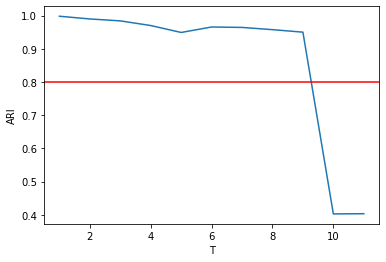

In [108]:
print("graph")

sns.lineplot(data=simulation_results, x="T", y="ARI")
# specifying horizontal line type
plt.axhline(y=0.8, color='r', linestyle='-')

### Simulation 2 : we take a period closer to the max purchase order date

In [ ]:
#T = 10 == un mois avant
nb_periods = 8 # deux mois avant 
n_days = 7